# Tim Ferris Cockpunch AI Art Competition 2022

2022-12-19

https://tim.blog/2022/12/16/ai-art-competition/

https://github.com/huggingface/diffusers

https://huggingface.co/blog/stable_diffusion

In [1]:
import os
os.chdir("../")
os.getcwd()

'/home/david/Projects/tf-cockpunch'

## Constants

In [2]:
IMAGE_SAVE_PATH = "/home/david/Pictures/2022-Cockpunch/"

In [3]:
from diffusers import StableDiffusionImg2ImgPipeline, DPMSolverMultistepScheduler, StableDiffusionPipeline, StableDiffusionDepth2ImgPipeline
from IPython.display import Image as img
from PIL import Image
import torch
from torch import autocast
from datetime import datetime
import json
from pathlib import Path

## Functions

In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Setup

In [5]:
PIPELINE_TYPE = "text2img"

In [6]:
if PIPELINE_TYPE == "img2img":
    # img2img
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-1", 
        torch_dtype=torch.float32,
        use_auth_token=True,
        # safety_checker=None,
    )
elif PIPELINE_TYPE == "depth2img":
    # dept2img
    pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-depth",
        torch_dtype=torch.float16,
        use_auth_token=True,
    ).to("cuda")
elif PIPELINE_TYPE == "text2img":
    pipe = StableDiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-1",
        torch_dtype=torch.float16,
        use_auth_token=True,
    ).to("cuda")
else:
    raise NotImplementedError

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/david/mambaforge/envs/sd2/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [7]:
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

In [8]:
pipe.to("cuda")
pipe.enable_attention_slicing()

## Load Initial Image

In [9]:
initial_image_path = "initial_images/487_v1.jpg"

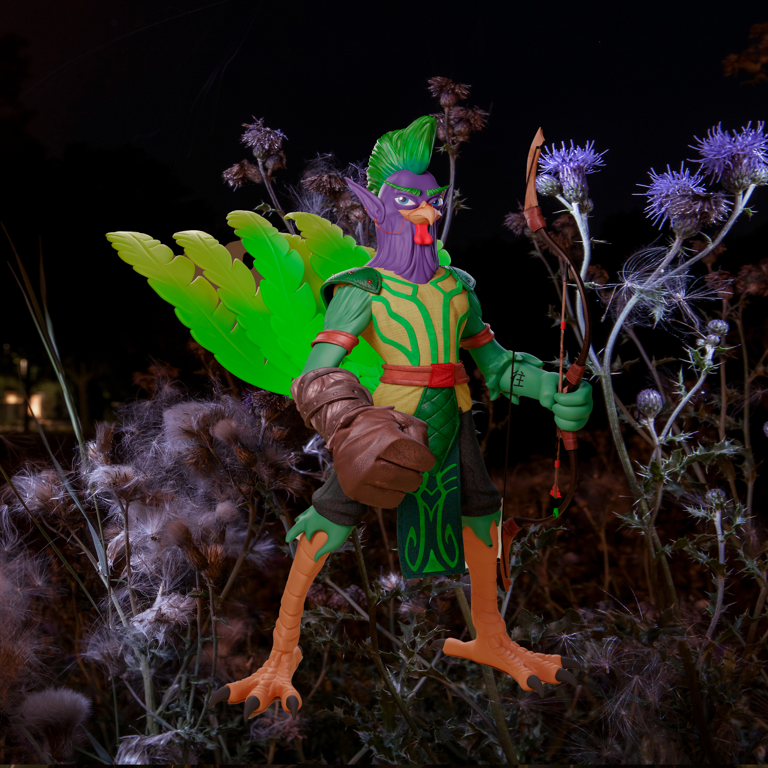

In [10]:
initial_image = Image.open(initial_image_path)
initial_image = initial_image.resize((768, 768))
initial_image

In [11]:
%%time
image_params = {
    "prompt": "(((rooster archer))), with (bow and arrow in left hand), feathers, elv-like, red mowhawk, (((beak))), standing in a ((forest)). dreamy light, intricate, oil painting, 18th century, yellow colors, animals, Rembrandt...",
    "negative_prompt": "((((ugly)))), (((duplicate))), ((morbid)), ((mutilated)), [out of frame], extra fingers, mutated hands, ((poorly drawn hands)), ((poorly drawn face)), (((mutation))), (((deformed))), ((ugly)), blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, (((disfigured))). out of frame, ugly, extra limbs, (bad anatomy), gross proportions, (malformed limbs), ((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), mutated hands, (fused fingers), (too many fingers), (((long neck)))((((ugly)))), (((duplicate))), ((morbid)), ((mutilated)), [out of frame], extra fingers, mutated hands, ((poorly drawn hands)), ((poorly drawn face)), (((mutation))), (((deformed))), ((ugly)), blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, (((disfigured))). out of frame, ugly, extra limbs, (bad anatomy), gross proportions, (malformed limbs), ((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), mutated hands, (fused fingers), (too many fingers), (((long neck)))",
    "seed": 42,
    "scale": 7.5,
    "strength": 0.8,
    "steps": 100,
    "creator": "LDW",
    "init_image_no": "idea_f",
    "pipeline_type": PIPELINE_TYPE
}

grid_file_name = (
    image_params["prompt"]
        .replace(" ", "_")
        .replace(".", "")
        .replace(",", "")
        .replace("'", "")
        .replace("(", "")
        .replace(")", "")
)
date_time = datetime.fromtimestamp(datetime.timestamp(datetime.now())).strftime('%Y%m%d_%H%M%S')
file_name = f"{IMAGE_SAVE_PATH}{image_params['init_image_no']}_{date_time}_{grid_file_name}.png"
Path(f"{IMAGE_SAVE_PATH}").mkdir(parents=True, exist_ok=True)

with open(f"{IMAGE_SAVE_PATH}image_parameters/{image_params['init_image_no']}_{date_time}_{grid_file_name}.json", "w") as fp:
        json.dump(image_params, fp)

print(file_name)

generator = torch.Generator("cuda").manual_seed(image_params["seed"])

result = pipe(
    prompt=image_params["prompt"], 
    negative_prompt=image_params["negative_prompt"],
    # image=initial_image, 
    # strength=image_params["strength"], 
    guidance_scale=image_params['scale'],
    num_inference_steps=image_params["steps"],
    num_images_per_prompt=4,
    generator=generator,
)   

print(result)

/home/david/Pictures/2022-Cockpunch/idea_f_20221221_020807_rooster_archer_with_bow_and_arrow_in_left_hand_feathers_elv-like_red_mowhawk_beak_standing_in_a_forest_dreamy_light_intricate_oil_painting_18th_century_yellow_colors_animals_Rembrandt.png


  0%|          | 0/100 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=768x768 at 0x7F2501051CD0>, <PIL.Image.Image image mode=RGB size=768x768 at 0x7F250B9AB0A0>, <PIL.Image.Image image mode=RGB size=768x768 at 0x7F2501005520>, <PIL.Image.Image image mode=RGB size=768x768 at 0x7F2501005490>], nsfw_content_detected=None)
CPU times: user 1min 21s, sys: 21.3 s, total: 1min 42s
Wall time: 1min 38s


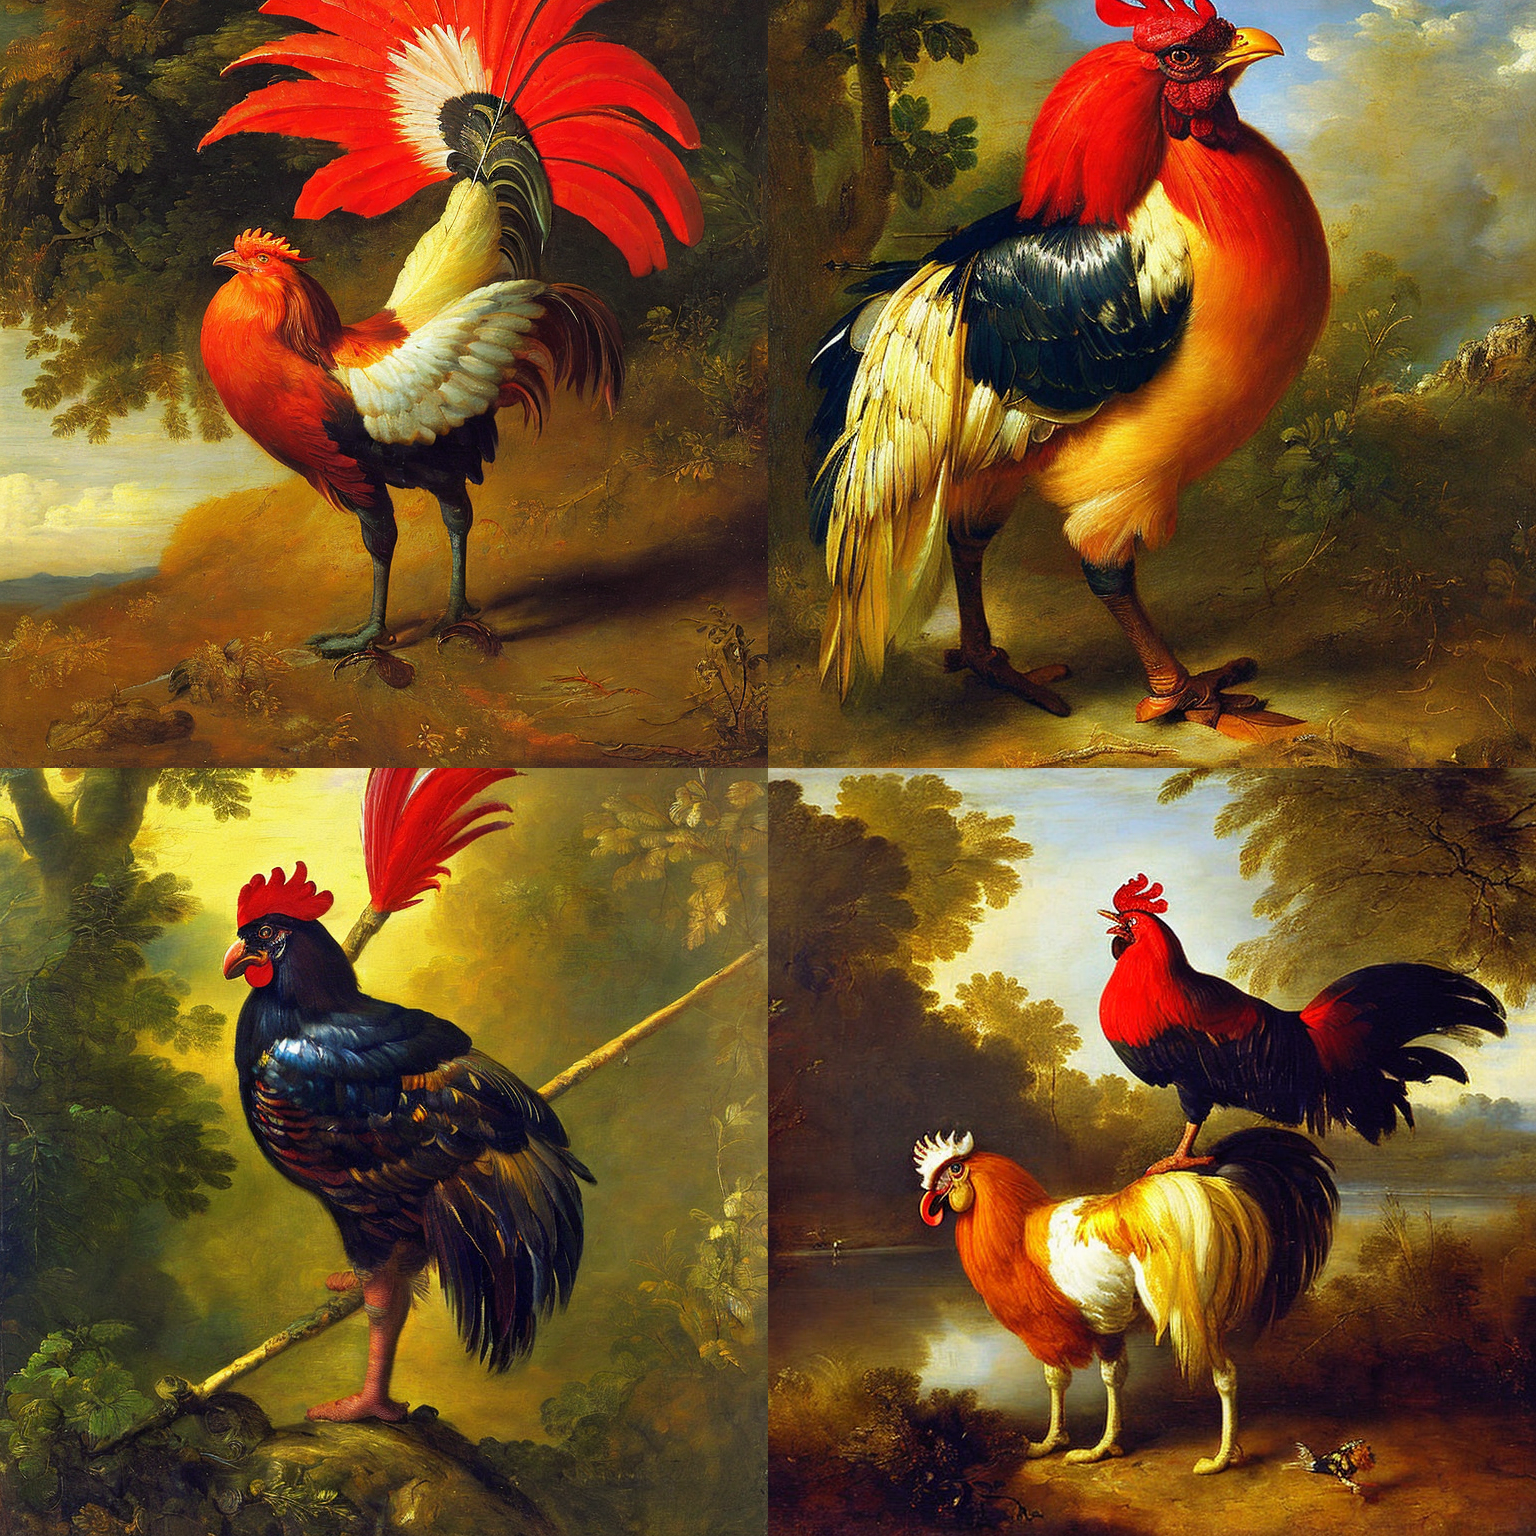

In [12]:
grid = image_grid(result["images"], rows=2, cols=2)
grid.save(file_name)
img(file_name)

In [ ]:
pic_of_interest = int(input())
selected_img = result["images"][pic_of_interest]
selected_img

In [ ]:
Path(f"{IMAGE_SAVE_PATH}{image_params['init_image_no']}/").mkdir(parents=True, exist_ok=True)
selected_img.save(f"{IMAGE_SAVE_PATH}{image_params['init_image_no']}/{date_time}.png")

## Further factors to play with

* scheduler

## ideas

- A: Combine with dead chicken photo from Lara
  - combining two images with SD is not possible
  - can only go from text2img or img+text2img, not merge/remix two images
- B: chicken race from forest
    - European naked neck chicken
    - Westfälischer Totleger
- C: a female cockpunch
- ~D: one pretty image~
- E: composition multiple cocks in one image
- F: chicks shredding machine


### Negative prompt recommendation:

```
((((ugly)))), (((duplicate))), ((morbid)), ((mutilated)), [out of frame], extra fingers, mutated hands, ((poorly drawn hands)), ((poorly drawn face)), (((mutation))), (((deformed))), ((ugly)), blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, (((disfigured))). out of frame, ugly, extra limbs, (bad anatomy), gross proportions, (malformed limbs), ((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), mutated hands, (fused fingers), (too many fingers), (((long neck)))((((ugly)))), (((duplicate))), ((morbid)), ((mutilated)), [out of frame], extra fingers, mutated hands, ((poorly drawn hands)), ((poorly drawn face)), (((mutation))), (((deformed))), ((ugly)), blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, (((disfigured))). out of frame, ugly, extra limbs, (bad anatomy), gross proportions, (malformed limbs), ((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), mutated hands, (fused fingers), (too many fingers), (((long neck)))
```